<a href="https://colab.research.google.com/github/eshika289/Overfitting-and-Regularization-Analysis-of-Neural-Networks/blob/main/Overfitting_and_Regularization_Analysis_of_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries/Frameworks

In [1]:
!pip install -U tensorflow_datasets
!pip install -q -U keras-tuner
!pip install pretty_confusion_matrix
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import math
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorboard.plugins.pr_curve import summary as pr_summary
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt

from sklearn.metrics import precision_recall_curve, confusion_matrix
from scipy import interp
from itertools import cycle

import pandas as pd
from pretty_confusion_matrix import pp_matrix


# Get & Visualize Data

In [ ]:
data = tf.keras.datasets.fashion_mnist
'''
(x_train_full, y_train_full), (x_test, y_test) = data.load_data() # Splitting Data into Train & Test Sets
x_train_full, x_test = x_train_full / 255.0, x_test / 255.0 # Normalizing Data
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42) # Splitting Data into Train & Validation Sets
'''
(x_train, y_train), (x_test, y_test) = data.load_data() # Splitting Data into Train & Test Sets
x_train, x_test = x_train / 255.0, x_test / 255.0 # Normalizing Data

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def show_image(x):
  pixel_plot = plt.figure()
  plt.title("pixel_plot")
  pixel_plot = plt.imshow(x, cmap='binary', interpolation='nearest')
  plt.colorbar(pixel_plot)
  plt.show(pixel_plot)

In [ ]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

def get_label(num):
  return labels[num]

In [ ]:
x_train[0].shape

(28, 28)

Each image has 28 x 28 pixels.

In [ ]:
get_label(y_train[0])

'Ankle boot'

The label for the first image in the training set is written above.

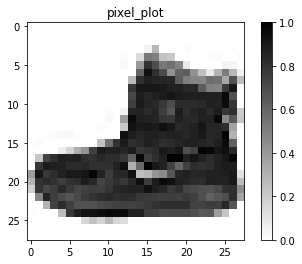

In [ ]:
show_image(x_train[0])

The 28 x 28 pixel plot of the first image in the training set is shown above.

# Part 1

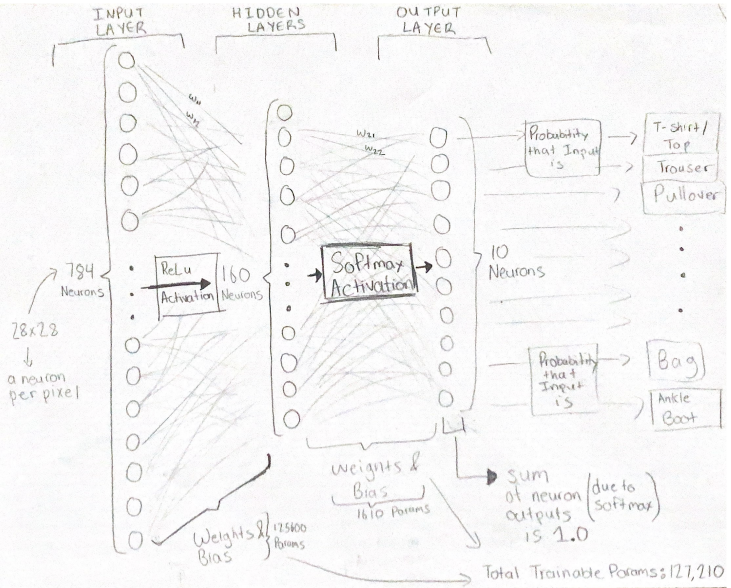

# Part 2 

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

### Hyperparameter Tuning

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of hidden layers
  # Choose an optimal value between 1-3
  hp_hidden_layer_count = hp.Int('hidden_layer_count', min_value=1, max_value=3, step=1)

  # Tune the number of units in the each Dense hidden layer
  # Choose an optimal value between 32-512
  max_units = 512
  for layer in range(hp_hidden_layer_count):
    hp_units = hp.Int('units'+str(layer), min_value=32, max_value=max_units, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    max_units = hp_units

  model.add(tf.keras.layers.Dense(10,activation='softmax'), )

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the optimizer type
  # Choose an optimal optimizer from sdg, adam
  hp_optimizer = hp.Choice('optimizer', values=['adam','SGD'])

  # Conditional for each optimizer
  if hp_optimizer == 'SGD':
    optimizer = tf.keras.optimizers.SGD(
      learning_rate=hp_learning_rate, 
      momentum=0.0, 
      nesterov=False,
    )
  elif hp_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(
      learning_rate= hp_learning_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07,
      amsgrad=False,
    )
    
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

**HYPERPARAMETER OPTIMIZATION STRATEGY**

The hyperparamter optimization strategy I am using is Hyberband.  This uses the Random Search algorithm with some additional features like resource allocation and successive halving to help speed up the search process.  It can also use the early stopping method where it stops testing a hyperparameter set if a certain metric (I used validation loss) has not improved over the past few epochs.

The Random Search alogorithm searches a random combination of the sets of hyperparameters and chooses the best performing hyperparameters among the ones tested.  This method doesn't guarentee that we get the best hyperparameters, but it runs much faster than the exhaustive Grid Search algorithm.

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss', #'val_accuracy'
                     max_epochs=10,
                     factor=3)

This code above is building a hyperband hyperparameter tuner that uses the model_builder function to build each model with a different set of hyperparameters.  The objective function in this tuner is the validation loss meaning it will choose a set of hyperparameters that results in a model that minimzes the validation loss.

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

The code above adds an early stopping callback which is monitoring the validation accuracy across epoch runs and if the validation accuracy has not improved by much during the past 5 epochs, it will stop searching that specific set of hyperparamters.

In [ ]:
tuner.search(x_train, y_train,  validation_split=0.2, callbacks=[stop_early], epochs=10) #epochs=20,

Trial 30 Complete [00h 00m 55s]
val_loss: 0.3132880926132202

Best val_loss So Far: 0.3132880926132202
Total elapsed time: 00h 14m 28s


The code above uses the tuner to search for an optimal set of hyperparameters.  It ran a total of 30 trials for 30 different sets of hyperparameters.

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print("These are the Hyperparameters that the tuner has decided minimizes the validation loss.\n")

print("Number of Hidden Layers:", best_hps.get('hidden_layer_count'))
print("Number of Hidden Neurons in the 1st Hidden Layer:",best_hps.get('units0'))
#print("Number of Hidden Neurons in the 2nd Hidden Layer:",best_hps.get('units1'))
#print("Number of Hidden Neurons in the 3rd Hidden Layer:",best_hps.get('units2'))
print("Learning Rate:",best_hps.get('learning_rate'))
print("Optimizer:",best_hps.get('optimizer'))

These are the Hyperparameters that the tuner has decided minimizes the validation loss.

Number of Hidden Layers: 1
Number of Hidden Neurons in the 1st Hidden Layer: 160
Learning Rate: 0.001
Optimizer: adam


In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

In [ ]:
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 10


The code above runs a model with the optimized hyperparameters for 50 epochs and chooses the epoch number that minimizes the validation loss.  Essentially, it is treating the number of epochs as a hyperparameter.  The aim of doing this is to avoid running the model for too long which could lead to overfitting the training set.

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5131 - accuracy: 0.8204 - val_loss: 0.4310 - val_accuracy: 0.8472
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3830 - accuracy: 0.8627 - val_loss: 0.3939 - val_accuracy: 0.8558
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3440 - accuracy: 0.8743 - val_loss: 0.3406 - val_accuracy: 0.8785
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3152 - accuracy: 0.8841 - val_loss: 0.3336 - val_accuracy: 0.8790
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3008 - accuracy: 0.8883 - val_loss: 0.3243 - val_accuracy: 0.8840
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2822 - accuracy: 0.8964 - val_loss: 0.3416 - val_accuracy: 0.8770
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2699 - accuracy: 0.8995 - val_loss: 0.3143 - val_accuracy:

Here we are running a model with the optimized hyperparamters and optimized number of epochs.

In [ ]:
hypermodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 160)               125600    
                                                                 
 dense_11 (Dense)            (None, 10)                1610      
                                                                 
Total params: 127,210
Trainable params: 127,210
Non-trainable params: 0
_________________________________________________________________


The code above showcases the architecture of the model selected by the hyperparameter tuner.

In [ ]:
train_loss, train_accuracy = hypermodel.evaluate(x_train,y_train)
test_loss, test_accuracy = hypermodel.evaluate(x_test,y_test)
generalization_error = np.absolute(test_loss-train_loss/train_loss)

print("[train loss, train accuracy]:", [train_loss,train_accuracy])
print("[test loss, test accuracy]:", [test_loss,test_accuracy])
print("Generalization Error",generalization_error)

313/313 [==============================] - 1s 2ms/step - loss: 0.3524 - accuracy: 0.8785
[train loss, train accuracy]: [0.24070537090301514, 0.9119833111763]
[test loss, test accuracy]: [0.3524151146411896, 0.8784999847412109]
Generalization Error 0.6475848853588104


The model performs well on both the test and training datasets.  The accuracy and loss of the test and training sets are not too far appart indicating that the model generalizes well (generalization error of about 0.65)


### Loss Per Iteration

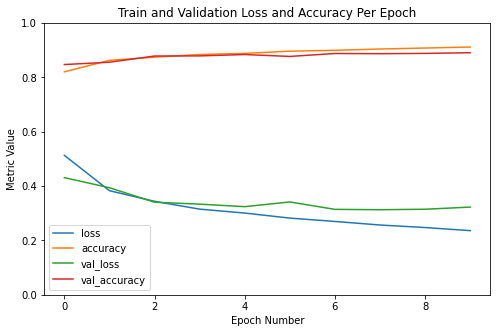

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title("Train and Validation Loss and Accuracy Per Epoch")
plt.xlabel("Epoch Number")
plt.ylabel("Metric Value")
plt.gca().set_ylim(0, 1)
plt.show()

The chart above shows how the training loss strictly decreases over the epochs and the training accuracy strictly increases of the epochs.  The validation accuracy and loss are very similar to the training loss and accuracy indicating that the model generalizes well and did not overfit the training set.

### Precision vs Recall Curve

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred):
    
    def change(y,idx):
      if y == idx:
        return 1
      return 0


    p = []
    r = []
    t = []
    for idx in range(len(labels)):
        y_act = [ change(y,idx) for y in y_test]
        y_hat = [ y[idx] for y in y_pred]
        precision, recall, thresholds = precision_recall_curve(y_act, y_hat)       
        p.append(precision)
        r.append(recall)
        t.append(thresholds)

    return p,r,t

1875/1875 [==============================] - 3s 2ms/step


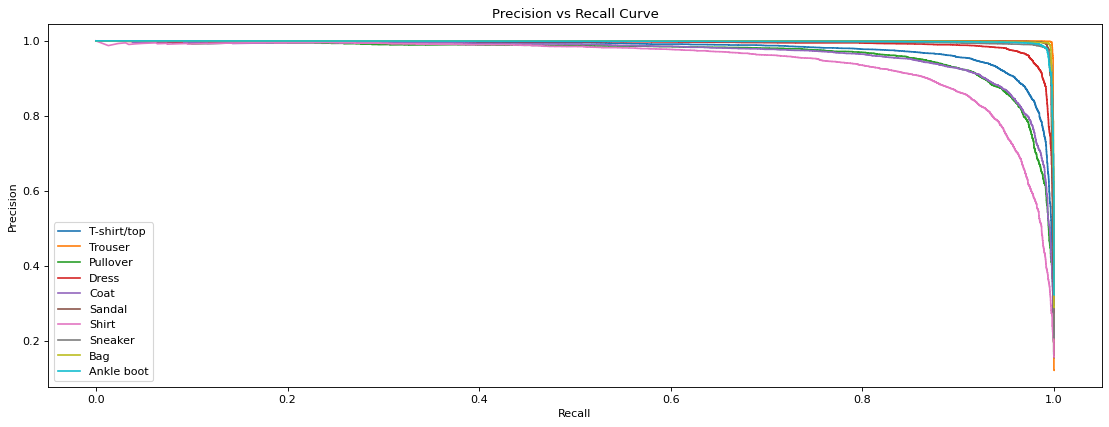

In [ ]:
p, r, t =  multiclass_roc_auc_score(y_train,model.predict(x_train))

#plt.rcParams["figure.figsize"] = (8,8)
plt.figure(figsize=(17, 6), dpi=80)

for i in range(len(p)):
  plt.plot(r[i],p[i], label=get_label(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve")

plt.legend()
plt.show()


The chart above showcases the precision vs recall curve and the tradeoff between precision and recall.  If the curves are closer the top-right corner, they indicate a smaller tradeoff between precision and recall for the model we evaluated on.  This chart specifically evaluates the precision vs recall curve for each class in the dataset.  To get a curve that represents all the classes, we can use micro-averaged or macro-averaged curves.  

### Confusion Matrix

In [ ]:
y_pred = np.array([np.argmax(y) for y in model.predict(x_test)])
cfm = confusion_matrix(y_test,y_pred)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(cfm)

[[870   0  12  22   5   1  85   0   5   0]
 [  5 970   2  15   6   0   1   0   1   0]
 [ 25   1 819   8  73   0  70   0   4   0]
 [ 28   6  26 883  32   1  19   0   5   0]
 [  4   0 108  22 806   0  57   0   2   1]
 [  0   0   0   1   1 959   0  21   2  16]
 [160   0  89  28  53   0 663   0   7   0]
 [  0   0   0   0   0  10   0 969   0  21]
 [  9   0   7   5   3   3   3   5 965   0]
 [  0   0   0   0   0   9   1  46   0 944]]


/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

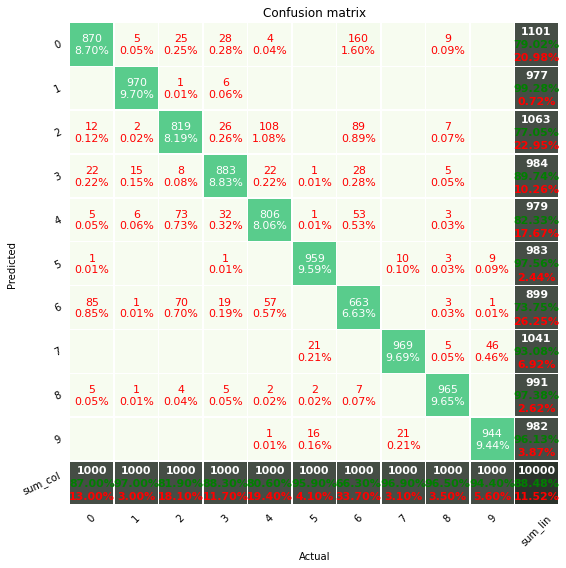

In [ ]:
df_cm = pd.DataFrame(cfm, index=range(0, 10), columns=range(0, 10))
cmap = 'GnBu'
pp_matrix(df_cm, cmap=cmap)

The chart above is the confusion matrix for this model. 

The rightmost column represents precision.

The bottom-most row represents recall. 

The bottom-right corner cell represents accuracy.

# Part 3

## Shuffle Pixels

In [ ]:
x_train_pixel_shuffle = np.array(x_train)

In [ ]:
for img in x_train_pixel_shuffle:
  img = img.reshape(28*28)
  np.random.shuffle(img)
  img = img.reshape(28,28)

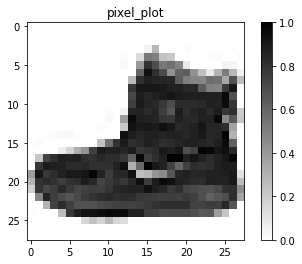

In [ ]:
show_image(x_train[0])

The image above is the orginal first x_train image.

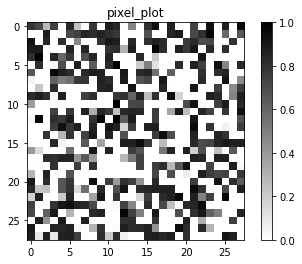

In [ ]:
show_image(x_train_pixel_shuffle[0])

The image above is the shuffled pixel version of the first x_train image.

## Build Model

In [ ]:
model2 = tf.keras.models.clone_model(hypermodel)

optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.001,
  beta_1=0.9,
  beta_2=0.999,
  epsilon=1e-07,
  amsgrad=False,
)
    
model2.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history = model2.fit(x_train_pixel_shuffle, y_train, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 5s 2ms/step - loss: 2.0121 - accuracy: 0.2164
Epoch 2/30
1875/1875 [==============================] - 7s 4ms/step - loss: 1.8200 - accuracy: 0.2949
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.6906 - accuracy: 0.3434
Epoch 4/30
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5763 - accuracy: 0.3902
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.4716 - accuracy: 0.4340
Epoch 6/30
1875/1875 [==============================] - 5s 3ms/step - loss: 1.3799 - accuracy: 0.4718
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.2859 - accuracy: 0.5122
Epoch 8/30
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2026 - accuracy: 0.5474
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1229 - accuracy: 0.5801
Epoch 10/30
1875/1875 [==============================] - 5s 3ms/step - loss: 1.053

Here we cloned the hypermodel from part 2 and are running it using the shuffled pixel x_train and the normal y_train.  The optimizer here is the accuracy.

## Evaluate Model

In [ ]:
train_loss, train_accuracy = model2.evaluate(x_train_pixel_shuffle,y_train)
test_loss, test_accuracy =model2.evaluate(x_test,y_test)
generalization_error = np.absolute(test_loss-train_loss/train_loss)

print("[train loss, train accuracy]:", [train_loss,train_accuracy])
print("[test loss, test accuracy]:", [test_loss,test_accuracy])
print("Generalization Error",generalization_error)

313/313 [==============================] - 1s 2ms/step - loss: 6.6578 - accuracy: 0.2287
[train loss, train accuracy]: [0.2723132371902466, 0.9109166860580444]
[test loss, test accuracy]: [6.65777587890625, 0.22869999706745148]
Generalization Error 5.65777587890625


Here we see that the training loss and accuracy are very similar to those from Part 2.  This indicates that the model can learn the label of an image even if the pixels of the image are randomly shuffled.  

One thing to note here is that it took the model about 30 epochs to reach about 88% accuracy with the shuffled pixels, but only took about 10 epochs to reach about 88% accuracy with the original image.

However, the test loss and accuracy indicate that the model performs poorly. It does not generalize well as it overfits the training dataset.  The generalization error is about 5.6.

## Loss Per Iteration

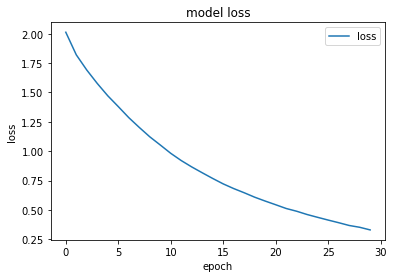

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'], label="loss")

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

The training loss decreases over each epoch.

## Precision vs Recall Curve

1875/1875 [==============================] - 3s 2ms/step


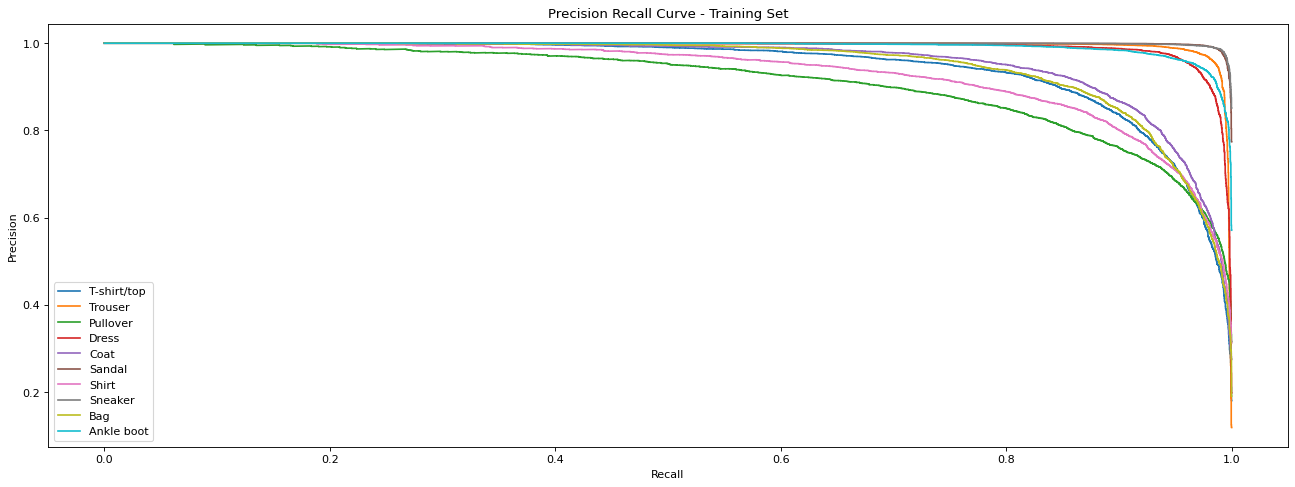

In [ ]:
p, r, t =  multiclass_roc_auc_score(y_train,model2.predict(x_train_pixel_shuffle))

plt.figure(figsize=(20, 7), dpi=80)

for i in range(len(p)):
  plt.plot(r[i],p[i], label=get_label(i))

plt.title("Precision Recall Curve - Training Set")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()
plt.show()


313/313 [==============================] - 1s 2ms/step


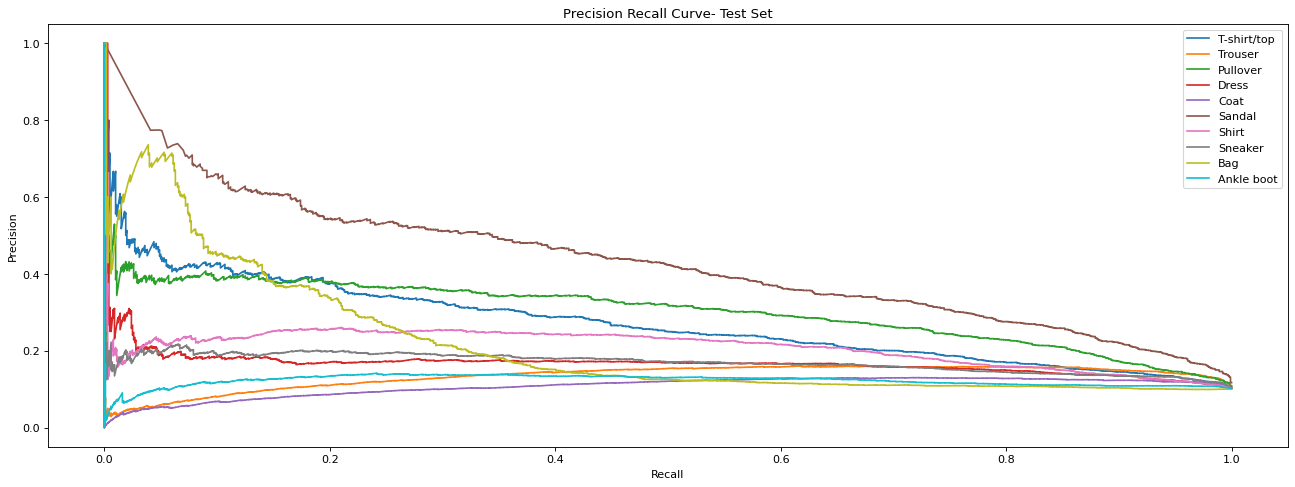

In [ ]:
#plt.rcParams["figure.figsize"] = (8,8)
p, r, t =  multiclass_roc_auc_score(y_test,model2.predict(x_test))

plt.figure(figsize=(20, 7), dpi=80)

for i in range(len(p)):
  plt.plot(r[i],p[i], label=get_label(i))

plt.title("Precision Recall Curve- Test Set")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()
plt.show()


The precision-recall curves show that the model performs well on the training set, but not the test set.

## Regularization & Early Stopping

### Build Model

In [ ]:
model3 = tf.keras.models.clone_model(hypermodel)

optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.001,
  beta_1=0.9,
  beta_2=0.999,
  epsilon=1e-07,
  amsgrad=False,
)
    
model3.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
history = model3.fit(x_train_pixel_shuffle, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 2.0320 - accuracy: 0.2097 - val_loss: 1.9272 - val_accuracy: 0.2422
Epoch 2/30
1500/1500 [==============================] - 4s 3ms/step - loss: 1.8306 - accuracy: 0.2951 - val_loss: 1.8900 - val_accuracy: 0.2449
Epoch 3/30
1500/1500 [==============================] - 6s 4ms/step - loss: 1.6956 - accuracy: 0.3469 - val_loss: 1.8654 - val_accuracy: 0.2664
Epoch 4/30
1500/1500 [==============================] - 6s 4ms/step - loss: 1.5718 - accuracy: 0.3988 - val_loss: 1.9158 - val_accuracy: 0.2507
Epoch 5/30
1500/1500 [==============================] - 5s 3ms/step - loss: 1.4515 - accuracy: 0.4487 - val_loss: 1.9395 - val_accuracy: 0.2567


Here I am building a model that takes into account the validation accuracy and loss by spliting the training dataset further into train and validation sets.  It also uses an early stopping callback to avoid running epochs if the validation loss does not improve.

### Evaluate Model

In [ ]:
train_loss, train_accuracy = model3.evaluate(x_train_pixel_shuffle,y_train)
test_loss, test_accuracy = model3.evaluate(x_test,y_test)
generalization_error = np.absolute(test_loss-train_loss/train_loss)

print("[train loss, train accuracy]:", [train_loss,train_accuracy])
print("[test loss, test accuracy]:", [test_loss,test_accuracy])
print("Generalization Error",generalization_error)

313/313 [==============================] - 1s 2ms/step - loss: 2.0043 - accuracy: 0.2379
[train loss, train accuracy]: [1.4309738874435425, 0.47253334522247314]
[test loss, test accuracy]: [2.004284143447876, 0.2379000037908554]
Generalization Error 1.004284143447876


The loss and accuracy of the training and test sets indicate that the model does not perform well.  This is because there is not a strong relationship between the shuffled pixel images and the labels.

With early stopping and a validation set, we reduced the overfitting of the training set indicated by the lower generalization error.  

# Part 4

## Shuffle Labels

In [ ]:
y_train_shuffled_labels = np.array(y_train)
y_train_shuffled_labels[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [ ]:
np.random.shuffle(y_train_shuffled_labels)
y_train_shuffled_labels[:10]

array([2, 0, 1, 6, 4, 2, 6, 7, 8, 1], dtype=uint8)

## Build Model

In [ ]:
model_4 =  tf.keras.Sequential()
model_4.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model_4.add(tf.keras.layers.Dense(units=320, activation='relu'))
model_4.add(tf.keras.layers.Dense(units=160, activation='relu'))
model_4.add(tf.keras.layers.Dense(10,activation='softmax'), )



optimizer = tf.keras.optimizers.SGD(
  learning_rate= 0.1, # I choose a high learning rate to show that the model can converge to a high accuracy
)
    
model_4.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
history_2 = model_4.fit(x_train, y_train_shuffled_labels, epochs=300)

Epoch 1/300
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3065 - accuracy: 0.0978
Epoch 2/300
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3029 - accuracy: 0.1008
Epoch 3/300
1875/1875 [==============================] - 5s 2ms/step - loss: 2.3024 - accuracy: 0.1031
Epoch 4/300
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3018 - accuracy: 0.1053
Epoch 5/300
1875/1875 [==============================] - 4s 2ms/step - loss: 2.3006 - accuracy: 0.1093
Epoch 6/300
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2992 - accuracy: 0.1102
Epoch 7/300
1875/1875 [==============================] - 5s 2ms/step - loss: 2.2977 - accuracy: 0.1115
Epoch 8/300
1875/1875 [==============================] - 4s 2ms/step - loss: 2.2959 - accuracy: 0.1125
Epoch 9/300
1875/1875 [==============================] - 5s 2ms/step - loss: 2.2934 - accuracy: 0.1155
Epoch 10/300
1875/1875 [==============================] - 5s 2ms/step - l

Here I ran this model with a high learning rate = 0.1 and for a large number of epochs = 300. I also added another hidden layer to increase the hypothesis set.

The model found weights/bias that achieve an accuracy of about 60%.  

## Evaluate Model

In [ ]:
train_loss, train_accuracy = model_4.evaluate(x_train,y_train_shuffled_labels)
test_loss, test_accuracy = model_4.evaluate(x_test,y_test)
generalization_error = np.absolute(test_loss-train_loss/train_loss)

print("[train loss, train accuracy]:", [train_loss,train_accuracy])
print("[test loss, test accuracy]:", [test_loss,test_accuracy])
print("Generalization Error",generalization_error)

313/313 [==============================] - 1s 2ms/step - loss: 11.7956 - accuracy: 0.1205
[train loss, train accuracy]: [1.0849181413650513, 0.5929333567619324]
[test loss, test accuracy]: [11.795574188232422, 0.12049999833106995]
Generalization Error 10.795574188232422


Here we see that the training loss and accuracy make it seem like the model performs somewhat okay with an accuracy of about 60%.  This indicates that the model can learn the label of an image even if the labels are completely random.  

One thing to note here is that model took about 300 epochs and has an additional hidden layer.  This all represents the fact that the target/ideal function is more complex than the functions in Part 2 & 3.  This is because the labels are randomized and there is no "real" relationship between the images and the labels.  Despite the fact that there is no real relationship, the model has a 60% accuracy on the train test.  How is this possible? The paper explains that the neural network is essentially just memorizing the training data exactly.  This showcases both the extreme overfitting that is happening here and the extreme complexities that neural networks are able to model (high effective capacity as the paper puts it).


The test loss and accuracy indicate that the model performs poorly. It does not generalize well as it overfits the training dataset.  The generalization error is about 10.8.

## Loss Per Iteration

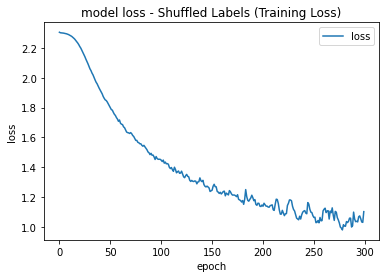

In [ ]:
# summarize history for loss
plt.plot(history_2.history['loss'], label="loss")

plt.title('model loss - Shuffled Labels (Training Loss)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

The training loss decreases over each epoch. The jumps towards the end is due to the higher learning rate I used.

## Precision vs Recall Curve

1875/1875 [==============================] - 3s 2ms/step


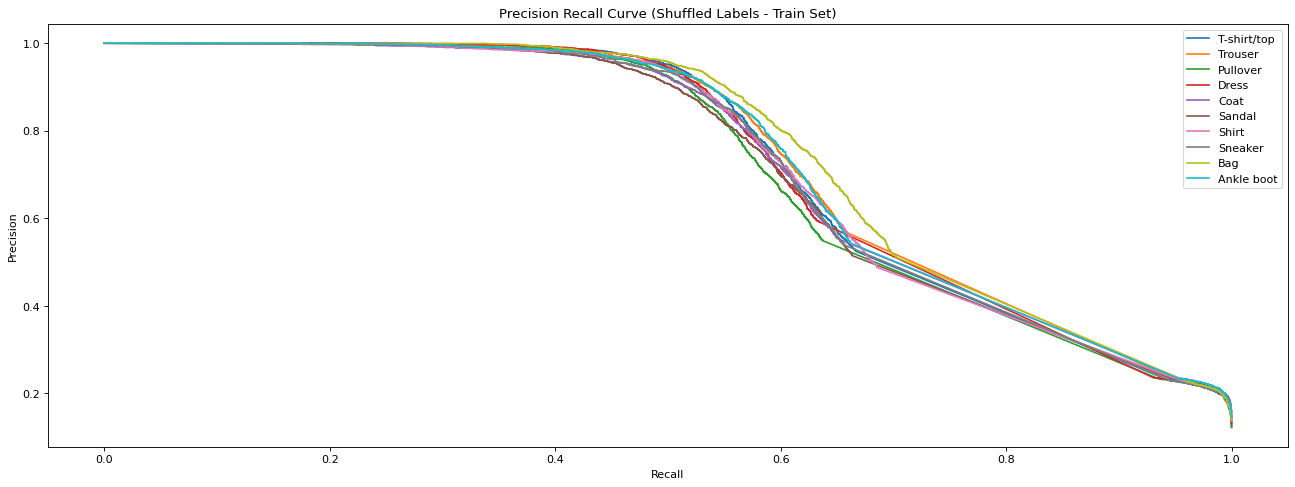

In [ ]:
#plt.rcParams["figure.figsize"] = (8,8)
p, r, t =  multiclass_roc_auc_score(y_train_shuffled_labels,model_4.predict(x_train))

plt.figure(figsize=(20, 7), dpi=80)

for i in range(len(p)):
  plt.plot(r[i],p[i], label=get_label(i))

plt.title("Precision Recall Curve (Shuffled Labels - Train Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()
plt.show()


The shape of this curve showcases that the model performs okay (not great) on the training set.

313/313 [==============================] - 1s 2ms/step


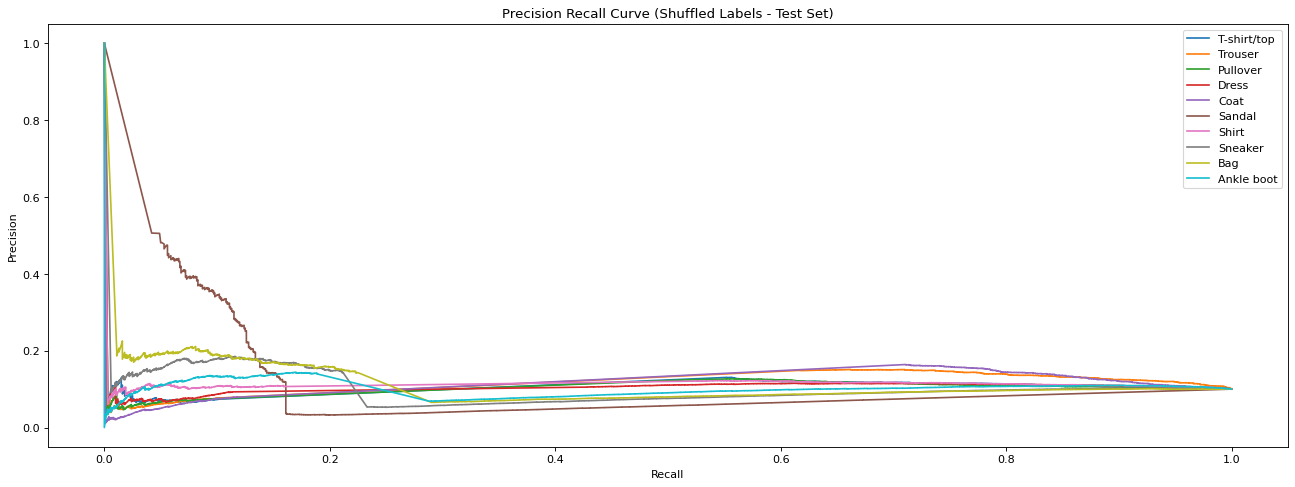

In [ ]:
#plt.rcParams["figure.figsize"] = (8,8)
p, r, t =  multiclass_roc_auc_score(y_test,model_4.predict(x_test))

plt.figure(figsize=(20, 7), dpi=80)

for i in range(len(p)):
  plt.plot(r[i],p[i], label=get_label(i))

plt.title("Precision Recall Curve (Shuffled Labels - Test Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.legend()
plt.show()


The chart shows that the model performs very poorly on the test set.

## Regularization & Early Stopping

### Build Model

In [ ]:
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model5.add(tf.keras.layers.Dense(320, activation='relu'))
model5.add(tf.keras.layers.Dense(160, activation='relu'))
model5.add(tf.keras.layers.Dense(10,activation='softmax'), )

optimizer = tf.keras.optimizers.Adam(
  learning_rate= 0.1,
  beta_1=0.9,
  beta_2=0.999,
  epsilon=1e-07,
  amsgrad=False,
)
    
model5.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [ ]:
history = model5.fit(x_train, y_train_shuffled_labels, epochs=300, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/300
1500/1500 [==============================] - 6s 4ms/step - loss: 3.3134 - accuracy: 0.1023 - val_loss: 2.3132 - val_accuracy: 0.1002
Epoch 2/300
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3156 - accuracy: 0.0985 - val_loss: 2.3160 - val_accuracy: 0.1028
Epoch 3/300
1500/1500 [==============================] - 6s 4ms/step - loss: 2.3142 - accuracy: 0.1001 - val_loss: 2.3105 - val_accuracy: 0.0959
Epoch 4/300
1500/1500 [==============================] - 7s 5ms/step - loss: 2.3160 - accuracy: 0.1006 - val_loss: 2.3204 - val_accuracy: 0.0972
Epoch 5/300
1500/1500 [==============================] - 5s 3ms/step - loss: 2.3147 - accuracy: 0.1009 - val_loss: 2.3168 - val_accuracy: 0.0972


Here I used early stopping and the model stopped after 5 epochs.

### Evaluate Model

In [ ]:
train_loss, train_accuracy = model5.evaluate(x_train,y_train_shuffled_labels)
test_loss, test_accuracy = model5.evaluate(x_test,y_test)
generalization_error = np.absolute(test_loss-train_loss)

print("[train loss, train accuracy]:", [train_loss,train_accuracy])
print("[test loss, test accuracy]:", [test_loss,test_accuracy])
print("Generalization Error",generalization_error)

313/313 [==============================] - 1s 3ms/step - loss: 2.3160 - accuracy: 0.1000
[train loss, train accuracy]: [2.3159115314483643, 0.10001666843891144]
[test loss, test accuracy]: [2.315950632095337, 0.10000000149011612]
Generalization Error 3.910064697265625e-05


The loss and accuracy of the training and test sets indicate that the model does not perform well.  This is because there is no "real" relationship between the images and the random labels.

With early stopping and a validation set, we reduced the overfitting of the training set indicated by the lower generalization error.  

# Part 5

## Information from Part 3

The training loss and accuracy are very similar to those from Part 2.  This indicates that the model can learn the label of an image even if the pixels of the image are randomly shuffled.  

One thing to note here is that it took the model about 30 epochs to reach about 88% accuracy with the shuffled pixels, but only took about 10 epochs to reach about 88% accuracy with the original image.  This indicates that the target function of the shuffled pixel problem may be more complex than the target function of the original problem of Part 2.

However, the test loss and accuracy indicate that the model performs poorly. It does not generalize well as it overfits the training dataset.  The generalization error is about 5.6.

## Information from Part 4

Here we see that the training loss and accuracy make it seem like the model performs decently well.  This indicates that the model can learn the label of an image even if the labels are completely random.  

One thing to note here is that model took about 300 epochs and has an additional hidden layer.  This all represents the fact that the target/ideal function is more complex than the functions in Part 2 & 3.  This is because the labels are randomized and there is no "real" relationship between the images and the labels.  Despite the fact that there is no real relationship, the model has a 60% accuracy on the train test.  

How is this possible? The paper explains that the neural network is essentially just memorizing the training data.  This showcases both the extreme overfitting that is happening here and the extremely complex functions that neural networks are able to model (high effective capacity as the paper puts it).


The test loss and accuracy indicate that the model performs poorly. It does not generalize well as it overfits the training dataset.  The generalization error is about 9.0.

## Regularization (Early Stopping & Validation Set)


The high loss and low accuracy of the training and test sets indicate that the model does not generalize well.  This is because there is not a strong relationship between the shuffled pixel images and the labels.

With early stopping and a validation set, we reduced the overfitting of the training set indicated by the lower generalization errors.

The paper discusses that we may be able to improve the generalization error using early stopping.  This is what we see in Part 3 & 4.